# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [490]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Data

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction

< y >
* **Price** : The price of the used car in INR Lakhs.



< X >
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [491]:
# Load Data
data = pd.read_csv("assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [492]:
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [493]:
data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [494]:
# 결측치 수가 비교적 적은 Mileage, Engine, Power, Seats의 경우, 결측치 제거
data.dropna(subset = ['Mileage', 'Engine', 'Power', 'Seats'], inplace=True)
data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                  0
Power                   0
Seats                   0
New_Price            5152
Price                   0
dtype: int64

# New_Price 결측값 처리
신차 가격과 관련이 있을 것으로 보이는 변수는 다음과 같다.

=> Year, Transmission, Mileage, Engine, Power

위 변수들을 활용하여 New_Price의 결측치를 채운다.

In [495]:
import re

# 연비 단위 조사
def extract_mileage_units(s):
    units = re.sub(r'\d+', '', str(s)).replace('. ', '')
    return units

units = data['Mileage'].apply(extract_mileage_units)

print(units.value_counts()) # 연비 단위 별 개수 출력

kmpl     5909
km/kg      66
Name: Mileage, dtype: int64


In [496]:
#kmpl 단위로 통일하여 변환
# 1 kg = 0.775L
# km/kg = 1km / 0.710 = 1.4084507 ... kmpl

def tokmpl(row):
    mileage = float(row['Mileage'].split(" ")[0])
    unit = row['Mileage'].split(" ")[1]
    if unit == 'km/kg':
        return mileage * 1.4
    else:
        return mileage

# 연비 단위 통일
data['Mileage'] = data.apply(tokmpl, axis=1)


In [497]:
def convert_power(x):
    try:
        if type(x) != float:
            return float(x[:-4])
        return x
    except ValueError:
        return np.nan

# 단위를 제거하여 숫자만 남기기
data['Power'] = data['Power'].apply(convert_power)
data['Engine'] = data['Engine'].apply(lambda x: int(x.split(" ")[0]) if type(x) == str else x)
data['Transmission'] = data['Transmission'].apply(lambda x: 0 if x.lower() == 'manual' else 1)
data['New_Price'] = data['New_Price'].apply(lambda x: float(x.split(" ")[0]) if type(x) == str else x)

data.isnull().sum()
#Power 열에서 결측값이 있는 것으로 확인됨 ('null bhp')

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                  0
Power                 103
Seats                   0
New_Price            5152
Price                   0
dtype: int64

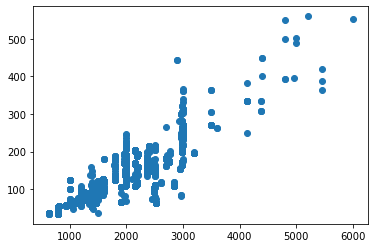

In [498]:
# Power 결측값 제거를 위해 Engine 데이터에 대한 선형회귀 결과를 통해 결측값을 채울 예정

# scatterplot 시각화 결과, Power와 Engine은 서로 선형 관계임을 확인
plt.scatter(x=data[data['Power'] != np.nan]['Engine'], y=data[data['Power'] != np.nan]['Power'])

In [499]:
from sklearn.linear_model import LinearRegression

# 결측치가 아닌 부분과 해당 부분의 다른 열들을 추출
non_missing_data = data.dropna(subset=['Power'])
X_train = non_missing_data['Engine']  # 다른 열들로 대체해야 함
y_train = non_missing_data['Power']

# 선형 회귀 모델 훈련
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train.values.reshape(-1, 1), y_train)

# 결측치가 있는 행 추출
missing_data = data[data['Power'].isnull()]
X_missing = missing_data['Engine']  # 다른 열들로 대체해야 함

# 선형 회귀 모델을 사용하여 결측치 예측
predicted_power = linear_reg_model.predict(X_missing.values.reshape(-1, 1))

# 결측치를 예측값으로 채우기
data.loc[data['Power'].isnull(), 'Power'] = predicted_power

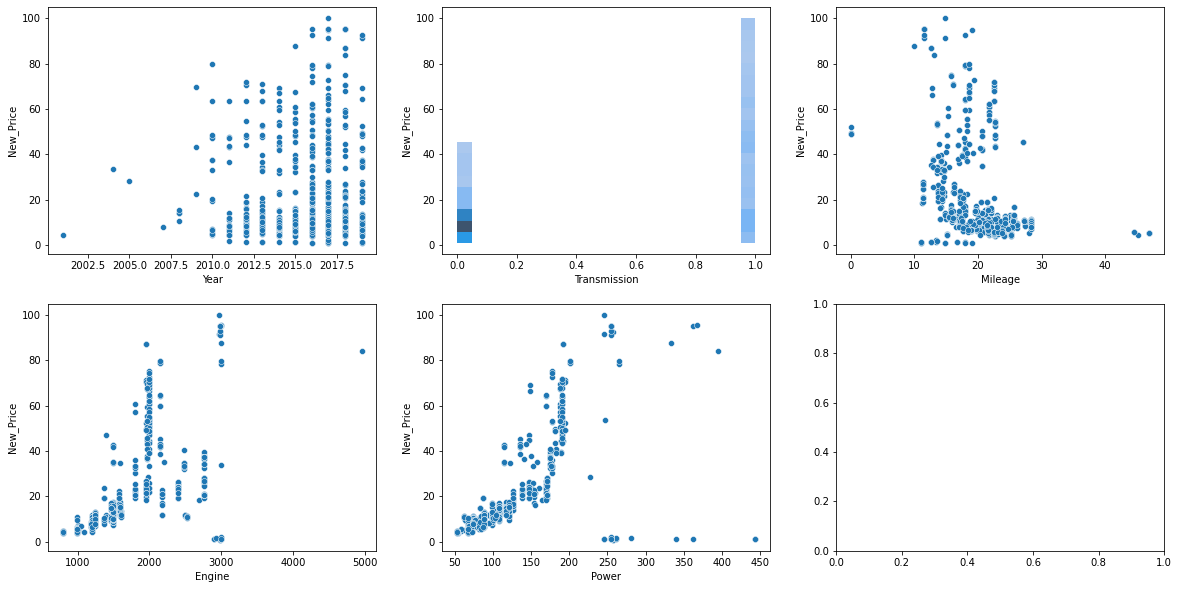

In [500]:
# New_Price 예측을 위한 변수들을 시각화
# 범주형 변수는 histplot / 연속형 변수는 scatterplot으로 New_Price와의 관계 시각화 진행

from sklearn.model_selection import train_test_split

fig, axs = plt.subplots(2,3,figsize=(20,10))
vars_for_newprice_pred = ['Year', 'Transmission', 'Mileage', 'Engine', 'Power']

newprice_data = data[data['New_Price'].notna()]


for idx, var in enumerate(vars_for_newprice_pred):
    r,c = idx // 3, idx % 3
    if var == 'Transmission' or var == 'Seats':
        sns.histplot(x=newprice_data[var], y=newprice_data['New_Price'], bins=20, kde=True, ax=axs[r,c])
    else:
        sns.scatterplot(x=newprice_data[var], y=newprice_data['New_Price'],
                                    palette='skyblue', ax=axs[r,c])

RandomForest Regressor를 통해 New_Price에 대한 회귀 예측 수행

In [501]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(newprice_data[vars_for_newprice_pred], newprice_data['New_Price'],
                                                    test_size=0.2, shuffle=True, random_state=42)

rf_model = RandomForestRegressor()

# 탐색할 매개변수 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# 그리드 서치 수행
grid_search.fit(X_train, y_train)

# 최적의 모델 획득
best_rf = grid_search.best_estimator_

# 테스트 세트에 모델 평가
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"테스트 세트 평균 제곱 오차 (MSE): {mse}")

# 학습시킨 모델을 통해 New_Price 결측치 채우기
data['New_Price'] = np.where(data['New_Price'].isna(), best_rf.predict(data[vars_for_newprice_pred]), data['New_Price'])

테스트 세트 평균 제곱 오차 (MSE): 34.10577231840868


# Price에 대한 선형회귀 모델 훈련 및 테스트

In [502]:
# Owner_Type에 대해 one-hot encoding 진행 
data['Owner_Type'] = data['Owner_Type'].apply(lambda x: 0 if x.lower() == 'first' else 1)

# Name, Location, Fuel_Type은 Price와 큰 연관성이 없으므로 제거
data.drop(['Name', 'Location', 'Fuel_Type'], inplace=True, axis=1)

data.head(10)

,Year,Kilometers_Driven,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,2010,72000,0,0,37.24,998,58.16,5.0,5.690120,1.75
1,2015,41000,0,0,19.67,1582,126.20,5.0,19.713788,12.50
2,2011,46000,0,0,18.20,1199,88.70,5.0,8.610000,4.50
3,2012,87000,0,0,20.77,1248,88.76,7.0,11.050165,6.00
4,2013,40670,1,1,15.20,1968,140.80,5.0,28.275250,17.74
5,2012,75000,0,0,29.54,814,55.20,5.0,4.549315,2.35
6,2013,86999,0,0,23.08,1461,63.10,5.0,9.339961,3.50
7,2016,36000,1,0,11.36,2755,171.50,8.0,21.000000,17.50
8,2013,64430,0,0,20.54,1598,103.60,5.0,12.046648,5.20
9,2012,65932,0,1,22.30,1248,74.00,5.0,8.622423,1.95


In [503]:
lin_model = LinearRegression() # 회귀 모델 생성

X = data.iloc[:,:-1]
y = data.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# 일차적으로 모델 훈련 및 테스트
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
print('mse 값: ', mean_squared_error(y_test, y_pred))

mse 값:  69.74060123776398


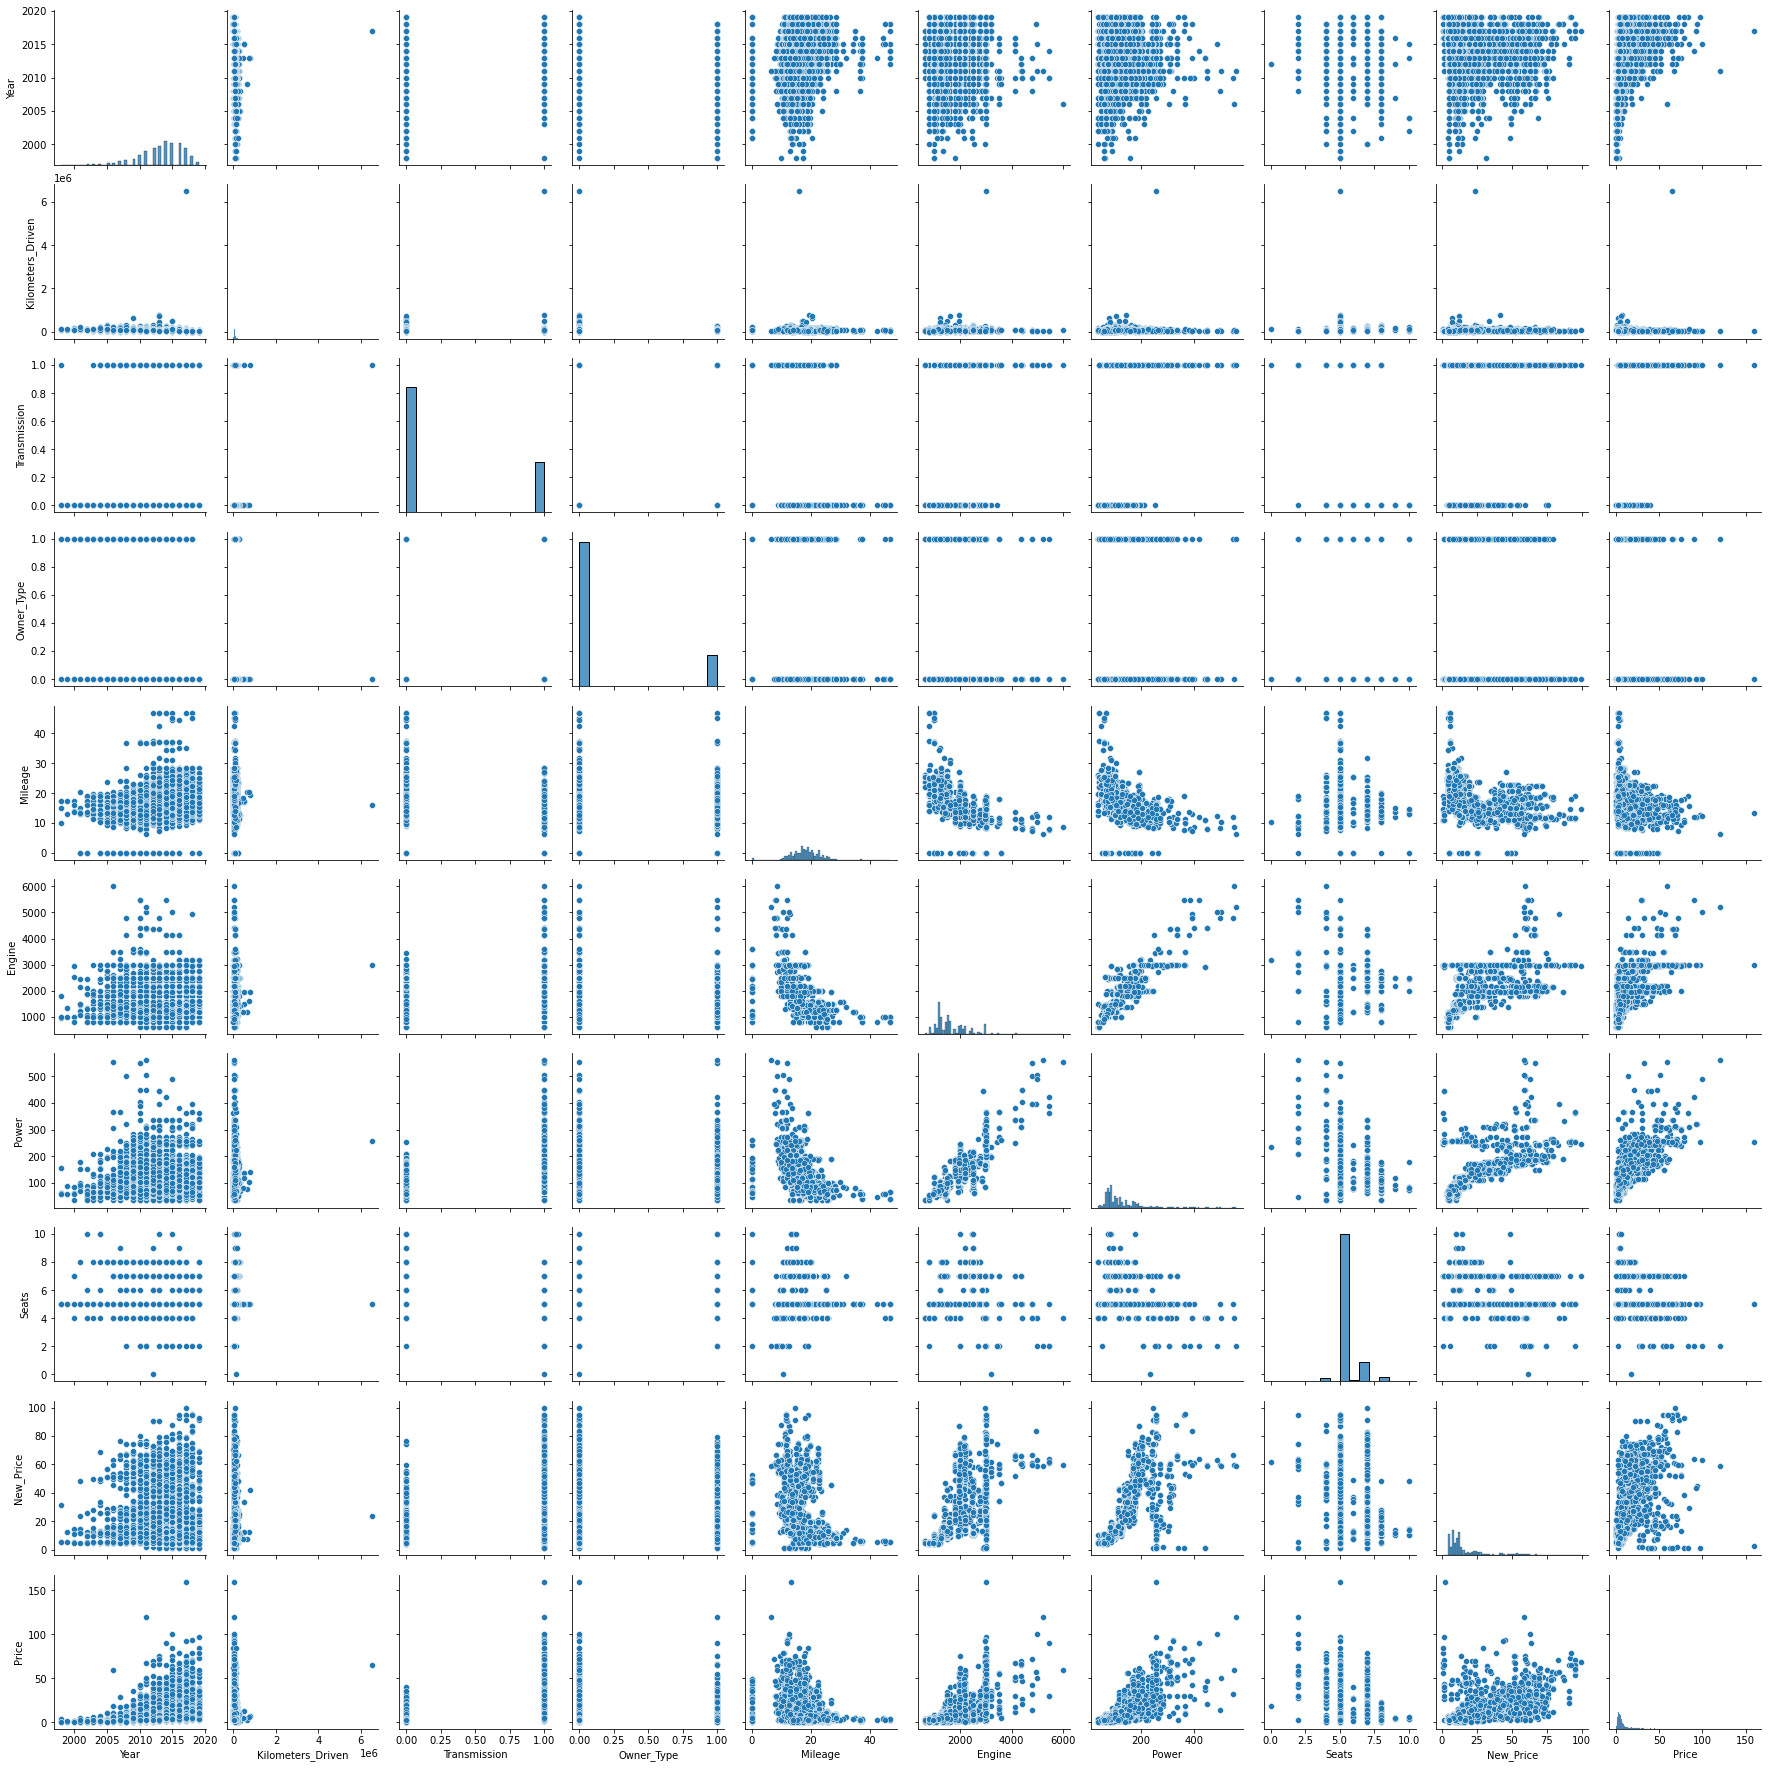

In [504]:
# 정확도 향상을 위해 회귀진단 진행
sns.pairplot(data)

"Power"-"Engine" 등에서 다중공선성이 발견됨

이를 수치화하여 나타내기 위해 각 feature 별 VIF 값 도출 작업 수행

In [505]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 상수 항 추가
X = sm.add_constant(X)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 출력
print(vif_data)

            Variable            VIF
0              const  532239.043895
1               Year       1.396155
2  Kilometers_Driven       1.047637
3       Transmission       2.044410
4         Owner_Type       1.161542
5            Mileage       1.775150
6             Engine       7.133466
7              Power       8.288664
8              Seats       1.756031
9          New_Price       3.241846


다중공선성이 10에 가깝게 나타나는 Engine과 Power 중 하나를 제거해야 함

In [506]:
from sklearn.metrics import r2_score

print(f'R-squared (Original): {r2_score(y_test, y_pred)}')

lin_model = LinearRegression()

X_power_removed = data.iloc[:,:-1].drop('Power', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_power_removed, y, test_size=0.2, shuffle=True, random_state=42)
lin_model.fit(X_train, y_train)
y_pred_power_removed = lin_model.predict(X_test)
r_squared_power_removed = r2_score(y_test, y_pred_power_removed)
print(f'R-squared (Power Removed): {r_squared_power_removed}')

X_engine_removed = data.iloc[:,:-1].drop('Engine', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_engine_removed, y, test_size=0.2, shuffle=True, random_state=42)
lin_model.fit(X_train, y_train)
y_pred_engine_removed = lin_model.predict(X_test)
r_squared_engine_removed = r2_score(y_test, y_pred_engine_removed)

print(f'R-squared (Engine Removed): {r_squared_engine_removed}')

R-squared (Original): 0.5209357154535698
R-squared (Power Removed): 0.4085976373151612
R-squared (Engine Removed): 0.5442855018558814


Engine 열을 제거했을 때 결정계수가 비슷한 수준으로 유지되므로, Engine feature를 삭제

In [507]:
X.drop('Engine', axis=1, inplace=True)
data.drop('Engine', axis=1, inplace=True)

In [508]:
# Engine 열을 제거한 데이터를 대상으로 회귀모델 훈련 재수행 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
print('mse 값: ', mean_squared_error(y_test, y_pred))

mse 값:  66.34141621180079


mse 값이 소폭 줄어든 것을 확인할 수 있음.

=> 오차의 등분산성을 확인하기 위해 시각화를 진행

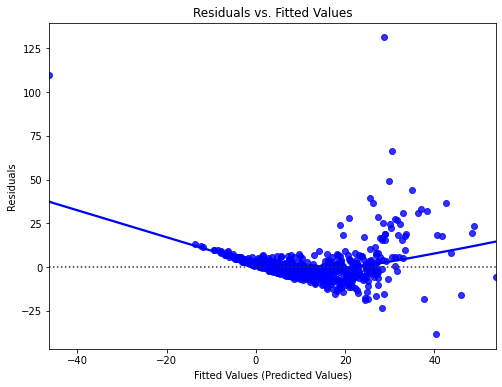

In [509]:
#잔차 계산
residuals = y_test - y_pred

# 잔차 대 예측값 그림 생성
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values (Predicted Values)')
plt.ylabel('Residuals')
plt.show()

band width가 일정하지 않으므로 오차의 분산이 일정하지 않다는 사실을 유추해볼 수 있음.

이를 해결하기 위해 독립변수 내 이상치를 제거하는 작업을 수행

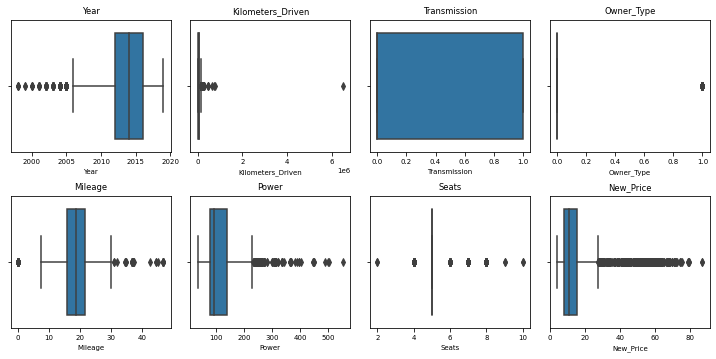

In [510]:
plt.rcParams.update({'font.size': 7})

# 이상치 시각화 함수
def visualize_outliers(df, feature, axs, r, c):
    sns.boxplot(x=df[feature], ax=axs[r,c])
    axs[r,c].set_title(f'{feature}')

# 이상치 제거 함수 (4분위수 활용)
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    df_no_outliers = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    return df_no_outliers


features = data.columns[:-1]
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10,5))

for idx, feature in enumerate(features):
    r = idx // 4
    c = idx % 4
    visualize_outliers(data, feature, axs, r, c)
    data = remove_outliers(data, feature)

plt.tight_layout()
plt.show()

In [511]:
# 이상치를 제거한 모델을 토대로 선형 회귀 모델 훈련
X = data.iloc[:,:-1]
y = data.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
print('mse 값: ', mean_squared_error(y_test, y_pred))

mse 값:  3.82739701930655


정확도가 이전보다 대폭 개선된 것을 확인할 수 있음

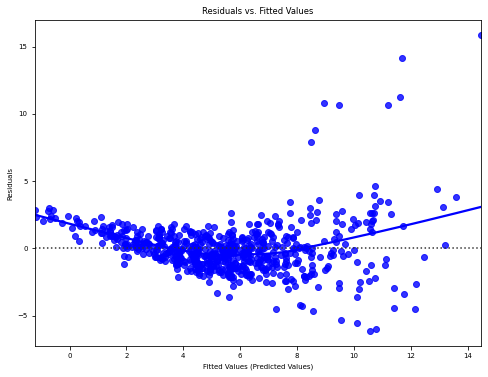

In [512]:
#잔차 계산
residuals = y_test - y_pred

# 잔차 대 예측값 그림 생성
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values (Predicted Values)')
plt.ylabel('Residuals')
plt.show()

오차의 등분산성 역시 이전에 비해 더 높아짐